Dataset Size: N = 10 samples
--------------------------------------------------------------------------------
Order (C)    Count        Frequency (%)
--------------------------------------------------------------------------------
1           97            97.00
2           3              3.00
3           0              0.00
4           0              0.00           * CORRECT *
5           0              0.00
6           0              0.00
7           0              0.00
8           0              0.00
9           0              0.00
10          0              0.00
--------------------------------------------------------------------------------

Statistics:
  Correct (C=4) selected: 0/100 (0.0%)
  Most frequently selected: C=1 (97.0%)
  Average selected order: 1.03


Dataset Size: N = 100 samples
--------------------------------------------------------------------------------
Order (C)    Count        Frequency (%)
----------------------------------------------------------------------

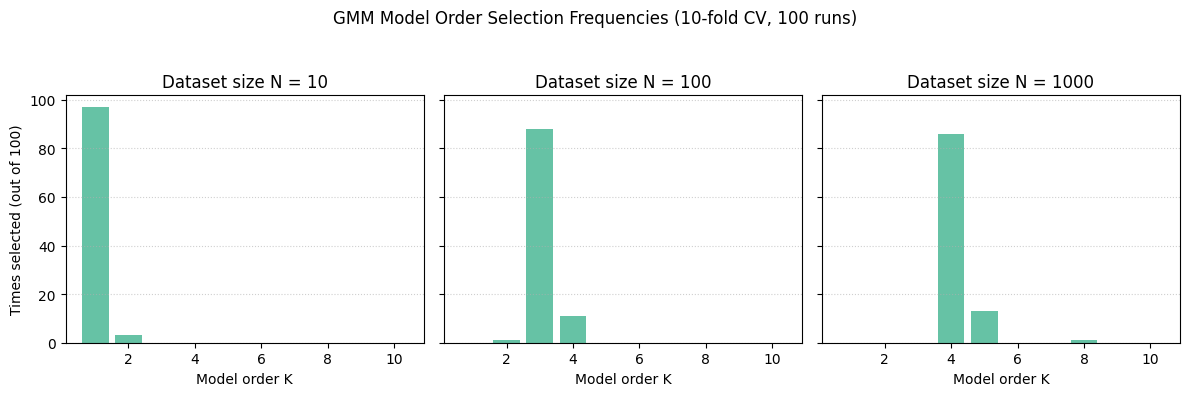

Saved files:
  q2_gmm_selection_rates.csv
  q2_gmm_selection_data.json
  q2_detailed_summary.txt
  q2_gmm_selection_histograms.png


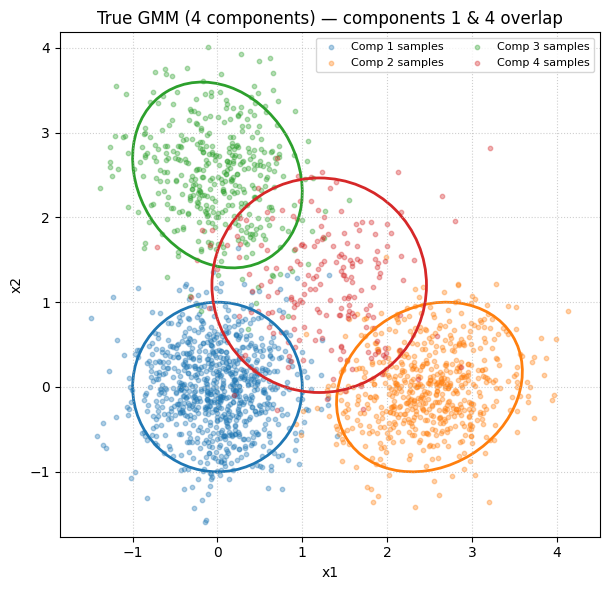

Saved: q2_true_gmm_components.png


In [3]:

import os
os.environ.setdefault("LOKY_MAX_CPU_COUNT", str(os.cpu_count() or 1))
os.environ.setdefault("SCIKIT_LEARN_DISABLE_JOBLIB_MULTIPROCESSING", "1")
os.environ.setdefault("JOBLIB_MULTIPROCESSING", "0")
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from collections import Counter
from matplotlib.patches import Ellipse
import json, csv

rng = np.random.default_rng(42)
TRUE_K = 4

true_means = np.array([
    [0.0, 0.0],
    [2.5, 0.0],
    [0.0, 2.5],
    [1.2, 1.2]  # intentionally overlapping with others
])

true_covs = np.array([
    [[0.25,  0.00], [ 0.00, 0.25]],
    [[0.30,  0.05], [ 0.05, 0.25]],
    [[0.25, -0.05], [-0.05, 0.30]],
    [[0.40,  0.00], [ 0.00, 0.40]],
])

# Non-uniform component weights (sum to 1.0), as required
true_weights = np.array([0.40, 0.30, 0.20, 0.10])

def sample_true_gmm(n):
    y = rng.choice(TRUE_K, size=n, p=true_weights)
    X = np.zeros((n, 2))
    for k in range(TRUE_K):
        idx = np.where(y == k)[0]
        if idx.size:
            X[idx] = rng.multivariate_normal(true_means[k], true_covs[k], size=idx.size)
    return X

def cv_log_likelihood(X, K_values, n_folds=10, seed=None):
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    results = {}
    for K in K_values:
        fold_ll = []
        for tr, va in cv.split(X):
            Xtr, Xva = X[tr], X[va]
            try:
                gmm = GaussianMixture(
                    n_components=K,
                    covariance_type='full',
                    random_state=seed,
                    n_init=2,
                    max_iter=200
                )
                gmm.fit(Xtr)
                # average log-likelihood per sample on validation
                fold_ll.append(gmm.score(Xva))
            except Exception:
                fold_ll.append(-np.inf)
        results[K] = float(np.mean(fold_ll))
    bestK = max(results, key=results.get)
    return bestK, results

def run_experiment(n_trials=100, sample_sizes=(10, 100, 1000), K_values=range(1, 11), n_folds=10):
    selection_counts = {N: Counter() for N in sample_sizes}
    all_cv_maps = {N: [] for N in sample_sizes}
    for t in range(n_trials):
        for N in sample_sizes:
            X = sample_true_gmm(N)
            bestK, cv_map = cv_log_likelihood(X, K_values, n_folds=n_folds, seed=1000 + t + N)
            selection_counts[N][bestK] += 1
            all_cv_maps[N].append(cv_map)
    return selection_counts, all_cv_maps

def sample_true_gmm_with_labels(n):
    """Same as sample_true_gmm but returns (X, y) with component labels for plotting."""
    y = rng.choice(TRUE_K, size=n, p=true_weights)
    X = np.zeros((n, 2))
    for k in range(TRUE_K):
        idx = np.where(y == k)[0]
        if idx.size:
            X[idx] = rng.multivariate_normal(true_means[k], true_covs[k], size=idx.size)
    return X, y

def draw_gaussian_ellipse(ax, mean, cov, color, nsig=2.0, lw=2, ls='-'):
    """Draw a nsig-sigma covariance ellipse for a 2D Gaussian."""
    vals, vecs = np.linalg.eigh(cov)
    order = np.argsort(vals)[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    width, height = 2 * nsig * np.sqrt(vals)
    ell = Ellipse(xy=mean, width=width, height=height, angle=theta,
                  fill=False, lw=lw, ls=ls, edgecolor=color)
    ax.add_patch(ell)


if __name__ == "__main__":
    sample_sizes = (10, 100, 1000)
    n_trials = 100
    selection_counts, all_cv_maps = run_experiment(n_trials=n_trials, sample_sizes=sample_sizes)

    # Save numeric summaries
    with open("q2_gmm_selection_rates.csv", "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["Model_Order(K)"] + [f"N={N}" for N in sample_sizes])
        for K in range(1, 11):
            w.writerow([K] + [selection_counts[N][K] for N in sample_sizes])

    with open("q2_gmm_selection_data.json", "w") as f:
        json.dump({
            "selection_counts": {str(N): dict(selection_counts[N]) for N in sample_sizes},
            "all_cv_maps": all_cv_maps
        }, f, indent=2)


    def print_dataset_block(N):
        counts = selection_counts[N]
        total = sum(counts[k] for k in range(1, 11))
        maxK = max(range(1, 11), key=lambda k: counts[k]) if total else 1
        avg_order = (sum(k * counts[k] for k in range(1, 11)) / total) if total else 0.0

        print(f"Dataset Size: N = {N} samples")
        print("-" * 80)
        print("Order (C)    Count        Frequency (%)")
        print("-" * 80)
        for k in range(1, 11):
            c = counts[k]
            freq = 100.0 * c / total if total else 0.0
            tag = "           * CORRECT *" if k == TRUE_K else ""
            print(f"{k:<12}{c:<13}{freq:>6.2f}{tag}")
        print("-" * 80)
        correct = counts[TRUE_K]
        print("\nStatistics:")
        print(f"  Correct (C={TRUE_K}) selected: {correct}/{total} ({(100.0*correct/total if total else 0.0):.1f}%)")
        print(f"  Most frequently selected: C={maxK} ({(100.0*counts[maxK]/total if total else 0.0):.1f}%)")
        print(f"  Average selected order: {avg_order:.2f}\n\n")

    # Print and also save to a .txt
    with open("q2_detailed_summary.txt", "w", encoding="utf-8") as out:
        for N in sample_sizes:
            import io, sys
            buf = io.StringIO()
            saved = sys.stdout
            sys.stdout = buf
            print_dataset_block(N)
            sys.stdout = saved
            block = buf.getvalue()
            print(block, end="")
            out.write(block)


    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    for i, N in enumerate(sample_sizes):
        ax = axes[i]
        counts = [selection_counts[N][K] for K in range(1, 11)]
        ax.bar(range(1, 11), counts, color="#66C2A5")
        ax.set_title(f"Dataset size N = {N}")
        ax.set_xlabel("Model order K")
        if i == 0:
            ax.set_ylabel(f"Times selected (out of {n_trials})")
        ax.grid(axis='y', linestyle=':', alpha=0.6)
    fig.suptitle(f"GMM Model Order Selection Frequencies (10-fold CV, {n_trials} runs)")
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.savefig("q2_gmm_selection_histograms.png", dpi=200)
    plt.show()

    print("Saved files:")
    print("  q2_gmm_selection_rates.csv")
    print("  q2_gmm_selection_data.json")
    print("  q2_detailed_summary.txt")
    print("  q2_gmm_selection_histograms.png")


X_vis, y_vis = sample_true_gmm_with_labels(2000)  # points only for visualization

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # C1..C4

fig, ax = plt.subplots(figsize=(6.2, 6.0))

# scatter per component (semi-transparent)
for k in range(TRUE_K):
    pts = X_vis[y_vis == k]
    if pts.size:
        ax.scatter(pts[:, 0], pts[:, 1], s=10, alpha=0.35, color=colors[k], label=f"Comp {k+1} samples")

# 2-sigma covariance ellipses
for k in range(TRUE_K):
    draw_gaussian_ellipse(ax, true_means[k], true_covs[k], colors[k], nsig=2.0, lw=2)

overlap_pair = (1, 4)
ax.set_title(f"True GMM (4 components) — components {overlap_pair[0]} & {overlap_pair[1]} overlap")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.axis('equal')
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend(loc='upper right', fontsize=8, ncol=2, frameon=True)

plt.tight_layout()
plt.savefig("q2_true_gmm_components.png", dpi=200)
plt.show()
print("Saved: q2_true_gmm_components.png")

